In [435]:
#to contain data
import pandas as pd
#to perform calculations
import numpy as np
#to plot data
import matplotlib.pyplot as plt
import seaborn as sns
#some libraries to do some statistical testing
from scipy import stats 
#import the Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

# About the Analysis I will do

Throughout this Notebook I will explore the time-dependent nature of GPC purchases contained in the [https://data.birmingham.gov.uk/dataset/purchase-card-transactions](Birmingham City Council purchase card transactions dataset) that I constructed from the monthly Excel files, covering a time-span from April 2014 up to January 2018 with some *gaps* (namely April 2015 and December 2017).  

The dataset analyzed here is composed of *purchase card transactions*, from Government Procured Cards (GPC from now on). According to the Ministry of Justice (check the [Government PRocurement Card Policy](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/219670/government-procurement-card-policy.pdf)), GPCs are a payment system operated via J.P. Morgan and are the the preferred method for *low value* goods and services. By law GPC cardholders must use their card solely for **official business purposes**, hence the need to monitor purchases done using GPC and the intention of the Birmingham City Council to make official purchases information transparent to UK citizens.

According to the GPC Policy Handbook, General Procurement Cards are supposed to be used for *low* value official purchases, and have strict transaction limits (see section 2.3 of the GPC Policy): 1000 GBP per day, and 5000 GBP per month, includingb VAT (Sales Tax). Moreover, GP Cards can either perform purchases or can receive *refunds* from unsatisfactory goods and services: these purchases and refunds show as transactions with positive and negative amounts in the dataset. 

However, as I will show in this Notebook, the 1000 GBP limit is not *respected* in many transactions. This situation is but *apparent*: several (but not all) Reports on the Birmingham City Council website featured a *currency* column, when the card was used in a transaction involving a currency other than GBP, the value registered for the transaction is the amount in the foreign currency and not in GBP, leading to numbers that apparently exceed this daily limit. 

When unifiying the Excel Reports from the Birmingham City Council website, such currency information was lost, due to the fact that this *currency* variable was only present in 12 of the 44 files examined, it was ignored when constructing the dataset that I am using in this Notebook. My study covers *all* of the reports from  the Birmingham City Council website: that is over a time-span that extends from April 2014 up to January 2018 with some month *gaps* where files were either not available (i.e. April 2015) or files were corrupt (i.e. december 2017). To see how I extracted this information and unified it into a single CSV file please check the other Notebook submitted (*data_gathering_and_cleanup.ipynb*), I disregarded variables from files that were *not* in *all* of them to have a consistent unified source. 

I wish to analyse two situations within the Birmingham GPC dataset:

- (1) *Trends* in GCP card transactions 
- (2) characterizing *unusual* transactions within the GPC system, taking into account that there are foreign currencies involved (i.e. *other* than Great British Pound).

For the first goal I will do some time-series analysis on the amounts (See the **Third Task** in this Notebook), dividing the series into purchases and refunds as previously described, and I will some time-series based statistical tests to determine if there are trends within purchases and refunds. For the second situation I will use a percentile division over transaction amounts and use the 1000 GBP daily transaction limit to construct a *likelihood* indicator that penalizes and prizes transactions within legal limits (See the **Fifth Task** in this Notebook). 

Though I present a very brief exploration of the categorical variables present in the dataset, the amount of categories within several of them renders them practically unusable (See the **Second Task** in this Notebook) as decision variables. Consequently, I will work solely with two variables present in the Birmingham City Council Dataset: the *amount* variable (to identify purchases and refunds and their values), and the *date* variable, to which I will add some fields (namely year and month) to check for seasonality.

As I will show, transaction amounts are not *normally* distributed (neither transactions nor refunds), hence classical statistical tests are not appropriate. My analysis relies heavily on statistical testing and classical probability theory, some of the results I will present derive from standard non-parametric statistical methods, some of them from my own cooking. 

## First Task: Open the dataset and check for correct types

I created a single unified CSV file, weighing almost 20MB, combining credit card payments combining all of the datasets provided by the Birmingham City Council between April 2014 and January 2018 (with some exceptions) in the Notebook called *data_gathering_and_cleanup.ipynb*. Now, I will perform some analysis on the cleaned date. First I have to load this file on to a pandas DataFrame: 

In [7]:
transactions = pd.read_csv('credit_card_transactions.csv',sep=';',decimal=',')
transactions.sample(10)

,index,amount,cac_desc_1,cac_code_3,cac_code_2,cac_code_1,merchant,date,card,cac_desc_2,vat_desc
108291,108452,46.42,Computing Other,A00,READY,L9Y0,amazon uk marketplace,2016-07-13,7229,Forrestdale JI,VZ
99449,99588,33.99,Equip Operational,A00,REAYQ,L100,www.trophystore.co.uk,2016-05-25,6470,Uffculme,VR
169189,169556,2314.45,Other Third Parties,A00,RJADC,N060,travelodge gb0000,2017-09-14,6316,Homeless Private Sector Accom,VR
48988,49014,3.30,Postage,A00,REAMB,L700,post office counter,2015-06-01,5845,St John & St Monica RC Junior & Infant,VZ
106573,106731,93.95,Security Contracts,A00,RDFAA,L5G0,harry smith ltd,2016-07-29,8542,Surplus EDC General Land & Buildings,VR
83042,83134,35.00,Supplies & Sev Mic,A00,REALH,MC70,www.ico.gov.uk,2016-01-18,2650,St Catherine's Of Siena RC J & I (NC),VZ
161084,161420,19.99,Books,A00,REAXF,L030,amazon uk marketplace,2017-07-10,2751,Turves Green Girls,VZ
89974,90092,31.95,Purchases Food,A00,REANY,L220,js online grocery,2016-03-09,6019,Thornton Junior,VZ
174863,175247,1420.00,Supplies & Sev Mic,A00,RHNBA,MC70,civil justice cent,2017-11-23,909,Central Arrears,VZ
49542,49568,65.17,Books,A00,REARY,L030,amazon uk retail,2015-05-26,2700,Yorkmead Junior & Infant,VZ


After opening this dataset, I will first check for data-types of variables. I am most interested in seeing the time-dependent aspect of this dataset. So let's check if I need to conver to datetime or to float. 

In [9]:
transactions.dtypes

index           int64
amount        float64
cac_desc_1     object
cac_code_3     object
cac_code_2     object
cac_code_1     object
merchant       object
date           object
card            int64
cac_desc_2     object
vat_desc       object
dtype: object

Effectively, the *date* variable was turned to a string (an *object*). So I will cast it to datetime using standard pandas methods. I wish also to add some fields to this DataFrame, that can account for seasonality: year, and month of the transaction. 

In [10]:
transactions['date']=pd.to_datetime(transactions['date'])
transactions['year'] = transactions['date'].dt.year
transactions['month'] = transactions['date'].dt.month_name()
transactions.sample(5)

,index,amount,cac_desc_1,cac_code_3,cac_code_2,cac_code_1,merchant,date,card,cac_desc_2,vat_desc,year,month
19281,19282,764.45,Computing Other,A00,REAXT,L9Y0,xma ltd,2014-09-03,7883,Cherry Oak,VZ,2014,September
171884,172265,10.99,Stationery,A00,REACD,L420,amazon.co.uk,2017-10-20,9533,Chad Vale Junior & Infant,VZ,2017,October
20317,20318,18.75,Purchases Food,A00,REAAB,L220,waitrose 796,2014-09-03,6968,The City of Birmingham School,NaN,2014,September
150891,151157,89.00,Equip Operational,A00,REALH,L100,paypal amazing,2017-05-10,2650,St Catherine's Of Siena RC J & I (NC),VZ,2017,May
66453,66509,7.00,Conference Fees Subs UK,A00,RUF0F,H0R0,chopstix,2015-09-24,9264,Illegal Money Lending T Stds Comm Inv.,VR,2015,September


## Second Task: Some observations regarding the variables contained in the dataset. 

Notice that besides the amount and the index of transactions, most variables are *categorical*. Let's see how many categories are in each of these variables. 

In [332]:
for var in transactions.columns:
    if var != 'index' and var != 'amount' and var !='month':
        num_categories = len(transactions[var].unique())
        print(var,num_categories)

cac_desc_1 143
cac_code_3 28
cac_code_2 1396
cac_code_1 143
merchant 15837
date 1332
card 1490
cac_desc_2 1381
vat_desc 8
year 6


Notice that there are over 15 thousand merchants, and over 1396 different CAC codes of the second level, alongside with 143 CAC codes of the first level. In addition, notice that we have purchases made with 1490 different cards. Meanwhile the second level purchase descriptions (*cac_desc_2*) features also thousands of categories). While I recognize that card number is most important, it is very messy to deal with categorical variables other than the VAT_DESC and perhaps the CAC code of the third level (with 28 values). 

Notice that the *vat_desc* variable features a lot of NaN. We will replace these NaN with N.G (Not Given) for the purpose of observing some basic measurements. 

In [336]:
transactions = transactions.fillna('N.G')

Now, in order to see how these categorical variables relate to both the number of transactions performed and the amounts that went through them. In order to see not only range but also density of transactions and amounts for a particular category, I favor *strip-plots* over bar-plots. They take a little bit longer, but they are more informative. 

The first strip plot will relate the category (horizontal axis) to the *amounts* involved (to the left) so we can see which category has the largest, smallest and most disperse amounts. To the right, I wish to introduce a strip plot that features the categories (horizontal axis) against  the *index of transactions* (using the *index* variable), the important thing about this plot are not the extension of the bars (since the index is in the range 0-184K), but the *density* of them. 

In [376]:
def cat_variable_stripplots(var_name):
    
    fig,subfigure = plt.subplots(1,2,figsize=(20,5),sharex=True)
    subfigure[0].set_title('Distribution of Amounts')
    subfigure[1].set_title('Indices of Transactions')
    sns.stripplot(data=transactions,x=var_name,y='amount',palette='Spectral',ax=subfigure[0])
    sns.stripplot(data=transactions,x=var_name,y='index',palette='viridis',ax=subfigure[1])
    sns.despine()
    plt.show()

Let's see the *vat_desc* variable that describes the type of *Sales tax* applied to the purchase. It has 8 categories:

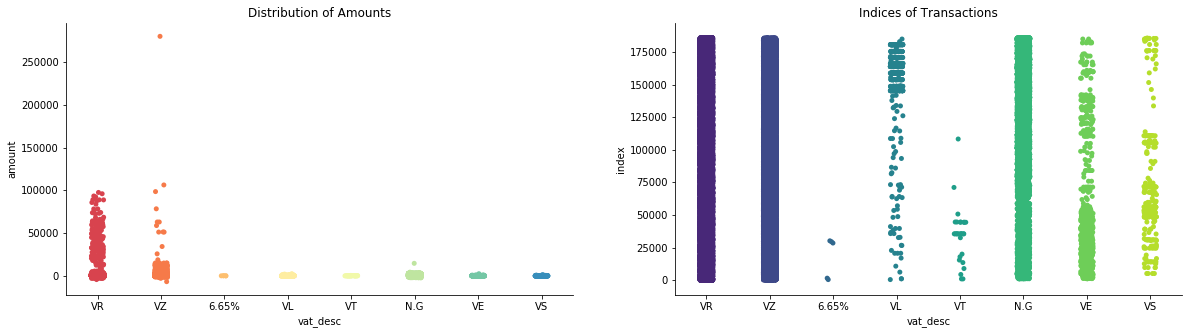

In [377]:
cat_variable_stripplots('vat_desc')

Notice that *VR* and *VZ* have the widest distribution of values: that is, transations taxed as *VR* and *VZ* are most common, and have values well above the 1000 GBP limit (recall that there are foreign currencies in the dataset) where *VZ* is the tax used for the largest transaction amount (over 250K). Meanwhile the other VAT categories are used in small amount transactions. If we look at the *index* of transactions, we see that *VR* and *VZ* are most common among transactions, alongside with the *N.G* category. This means that the VAT was not specified for a large amount of transactions and was used throughout time. In contrast the 6.65% and the *VT* tax were seldomly used in transactions (their bars ar short and sparse), and while *VE* and *VS* are used exclusively for *small* transactions, they were also profusely used throughout the dataset. 

LEt's have a look now to the *CAC Code 3* variable, with 28 different categories. 

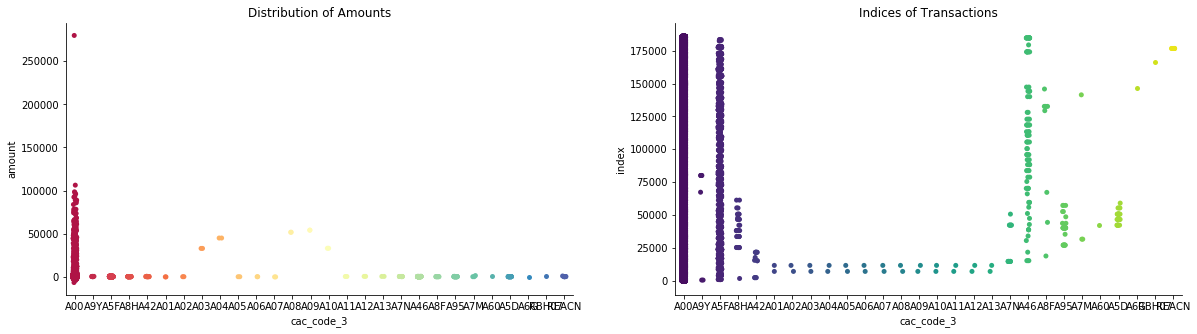

In [378]:
cat_variable_stripplots('cac_code_3')

Notice that out of the 28 codes, the A00 Code is used in transactions covering the whole span of amounts, while most of the other CAC codes are used only for small amount transactions except for the 2AD, 3AD, 4AD codes, that were used solely for transactions around (and above) 5000. If we look to the indices of transactions, we see that the A00 code is most popular, alongside with A51 and NA46. It is curious to see that although the last codes are used solely for small amount transactions the number of them is increasing (see the upwards trend on the right-side plot). 

Now, in order to see the transation amounts and indices concerning *cards* there are almost 1500 cards present in the Birmingham City Council dataset. Instead of using strip plots, I will use histograms, to see the distribution of average amount *moved* by a card (combining both refunds and purchases) to the left, and the frequency of use of cards (to the right). 

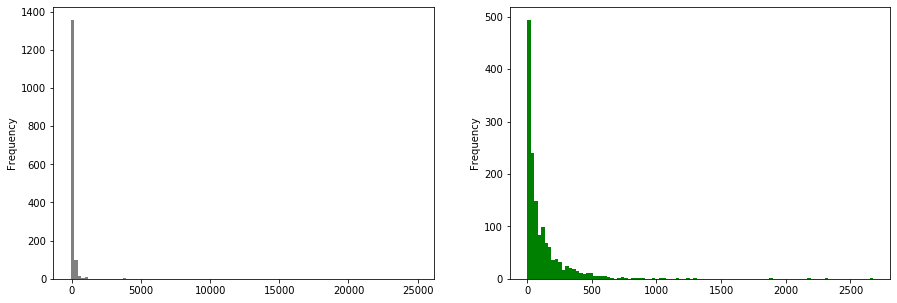

In [470]:
card_pivot = pd.pivot_table(transactions,
                           index='card',
                           values=['index','amount'],
                           aggfunc={'index':'count',
                                   'amount':'mean'})
fig,subfigure = plt.subplots(1,2,figsize=(15,5))
card_pivot['amount'].plot.hist(bins=100,ax=subfigure[0],color='grey')
card_pivot['index'].plot.hist(bins=100,ax=subfigure[1],color='green')
plt.show()

As previously stated, cards are used mostly within the regulations stated in the GPC policy: cards should be used for *small* purchases (notice how skewed to the left is the amount distribution), be warned that since we are combining refunds and purchases (positive and negative amounts). Notice that the support of average amount per card is limited to 2500, while there are purchases of over 250000, in this case this average is not appropriate and I will ellaborate on this in the next section. Notice also that the number of times that a card is used is also skewed heavily to the left, with most of the cards being used for in between 0 and 500 transactions throughout time. 

##  Third Task: Prevalence of *purchases* and *refunds* in the Birmingham City Council Dataset

Upon revision of the GPC policy, Section 5.4 (*Distpued Transactions and unsatisfactory goods and services*), states that GPC card holders can obtain *refunds* from unsatisfactory goods or services. As a consequence, transactions within the Birmingham City Council dataset can be for amounts *positive* (i.e. purchases), or *negative* (i.e. refunds).   

First, let's see some basic exploratory statistics from the *amount* variable over the time-span I'm analyzing (from april 2014 up to early 2018). 

In [202]:
transaction_stats = transactions['amount'].describe()
transaction_stats

count    185480.000000
mean        181.412025
std        1733.355189
min       -6794.000000
25%          12.790000
50%          40.500000
75%          92.250000
max      280102.230000
Name: amount, dtype: float64

Notice that we have a minimum and maximum amount values that stretch the support of the amount variable in the range $[-6794, 280102.23]$. Though the GCP Policy states that GCP cards have a maximum *daily* transaction limit of 1000 GBP, and a maximum monthly credit limit of 5000 GBP, the maximum purchase found amounts to 280102.23. However, some of the Datasets in the Birmingham City Council reports feature a *currency* variable. In this sense, these transactions in the realm of hundreds of thousands may very well be in currencies other than GBP.  

I wish to see first, the prevalence of purchases and refunds in the dataset: 

In [209]:
pos_prevalence = float(len(transactions.loc[transactions['amount']>0]))/float(transaction_stats['count'])
neg_prevalence = float(len(transactions.loc[transactions['amount']<0]))/float(transaction_stats['count'])
zero_prevalence = float(len(transactions.loc[transactions['amount']==0]))/float(transaction_stats['count'])
print('prevalence of positive transactions',"{:,.2f}%".format(100*pos_prevalence))
print('prevalence of zero transactions',"{:,.2f}%".format(100*zero_prevalence))
print('prevalence of negative transactions',"{:,.2f}%".format(100*neg_prevalence))

prevalence of positive transactions 97.27%
prevalence of zero transactions 0.00%
prevalence of negative transactions 2.73%


We have an overwhelming majority of purchases: 97.27%, and only 2.73% refunds. Let's see now, how purchases and refunds evolve in time, seeing *amount* as a function of time (i.e. a time-series). On top I will show the purchases (in blue) and in the bottom the reunfds (in red).

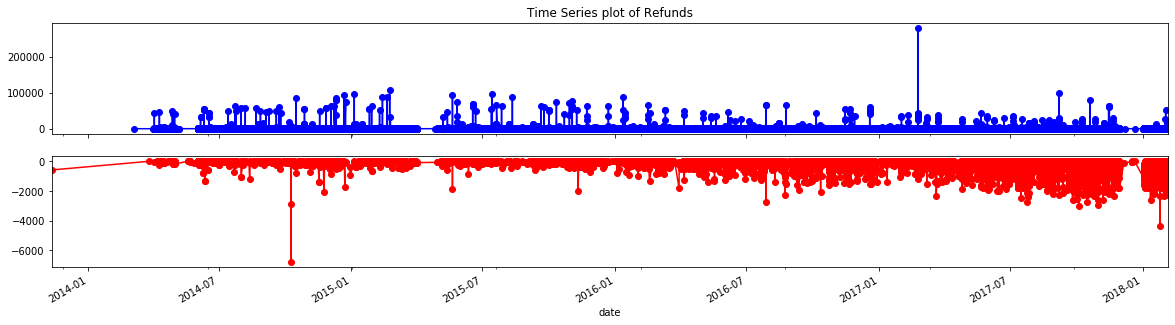

In [393]:
#create the time series
amount_series = transactions[['date','year','month','amount']]
#sort the dataset by date
amount_series = amount_series.sort_values(by='date',
                                          ascending=True)
#make the series a datetime indexed series
amount_series = amount_series.set_index('date')
#let's see the result
fig,subfigure = plt.subplots(2,1,figsize=(20,5),sharex=True)
subfigure[0].set_title('Time Series plot of Purchases')
subfigure[0].set_title('Time Series plot of Refunds')
amount_series.loc[amount_series['amount']>0]['amount'].plot(ax=subfigure[0],color='blue',marker='o')
amount_series.loc[amount_series['amount']<0]['amount'].plot(ax=subfigure[1],color='red',marker='o')
plt.show()

Notice that there are gaps within the time series at the start: though the files in the Birmingham City Council are reported to start in April 2014, we have records dating back before January 2014 (a single refund). There seems to be a gap from January 2014, up until March 2014, and then a small gap before the start of April-2014. In addition, there are other small gaps: April 2015 (report is not listed on the Birmingham City Council Website), and December 2017 (File was corrupt).

Notice that refunds are scattered throughout time, but contrary to purchases, there is an increase in refunds from 2016 onwards (perhaps consistently). There are also *spikes* in both purchases and refunds for values beyond the 1000 GBP daily limit. However, recall that currency was not accounted for in my dataset, and hence we cannot know for sure if transactions respect the daily limit in GBP. However, as stated in the GPC policy document, GPC are intended to be used for *low value purchases*: as we will see in upcoming sections, most of the transactions do respect the daily limit (including currency exchange).  

## Fourth Task:  Determining the Existence of Trends in GCP Transactions 

Before analyzing purchase and refund amounts, I wish to first see if GPC purchases (official purchases) are time dependent. 
Contrary to civilian transactions, where purchasing may increase depending on holidays, GCP purchases are government funded and should remain somehow *constant* throughout the year. However, as we have previously seen, *refunds* on GCP cards began increasing in amount from 2016 onward. Could this be due to a currency exchange (i.e. that the british government is spending more in foreign currencies)? 

First let's divide the dataseries into the *pos_series* for *purchases* and the *neg_series* for *refunds*. And let's see some time-series plots accounting for weekly, monthly and trimestral *medians* (since the data is heavily skewed towards lower values). 

In [397]:
pos_series = amount_series.loc[amount_series['amount']>0]
neg_series = amount_series.loc[amount_series['amount']<0]

In [398]:
def plot_averages_series(time_series,subfigure):
    week_series = time_series.resample('W').median()
    month_series = time_series.resample('M').median()
    trimestral_series = time_series.resample('3M').median()
    subfigure.plot(time_series['amount'],linestyle='-',
                   linewidth=0.3,label='daily count',markersize=2, color='orange')
    subfigure.plot(week_series['amount'],marker='o',markersize=3,
            linestyle='-',linewidth=0.6,label='weekly average',color='darkgray')
    subfigure.plot(month_series['amount'],marker='o',markersize=3,
            linestyle='-',linewidth=0.7,label='monthly average',color='red')
    subfigure.plot(trimestral_series['amount'],marker='o',markersize=3,
            linestyle='-',linewidth=0.8,label='trimestral average',color='black')
    subfigure.legend()

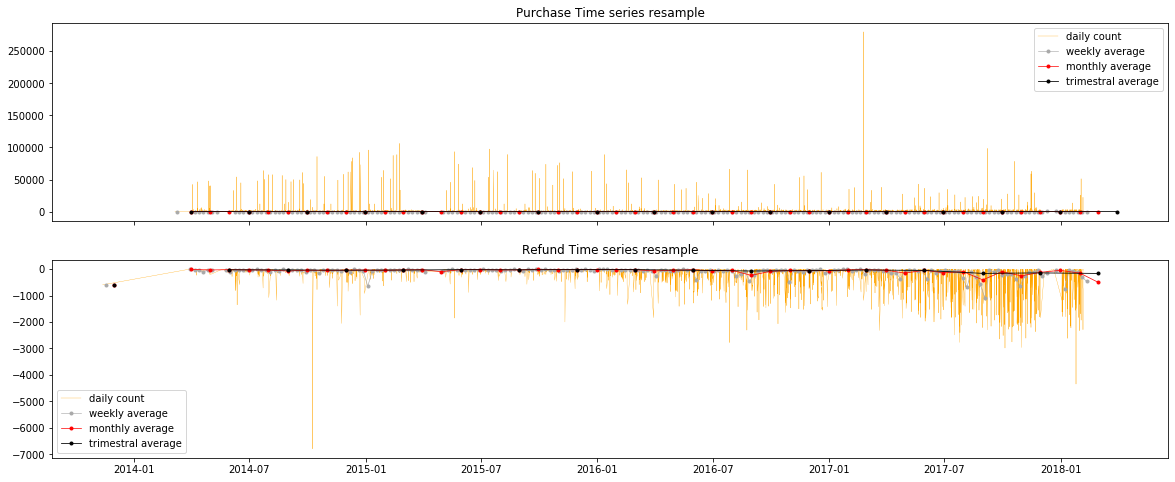

In [399]:
fig,subfigure = plt.subplots(2,1,figsize=(20,8),sharex=True)
subfigure[0].set_title('Purchase Time series resample')
subfigure[1].set_title('Refund Time series resample')
plot_averages_series(pos_series,subfigure[0])
plot_averages_series(neg_series,subfigure[1])
plt.show()

As expected notice that altough there are *spikes* in larger purchases and refunds throughout the dataset, purchases have an almost *flat* average (suggesting *stationarity*). More plainly: purchases have not increased nor decreased throughout time. Moreover, notice that purchases have average values well below the 5000 monthly limit. In contrast the averages for refunds slightly increased in time, only in certain dates, driven by a lot of refunds that look to be *above* the limit of 1000 GBP. 

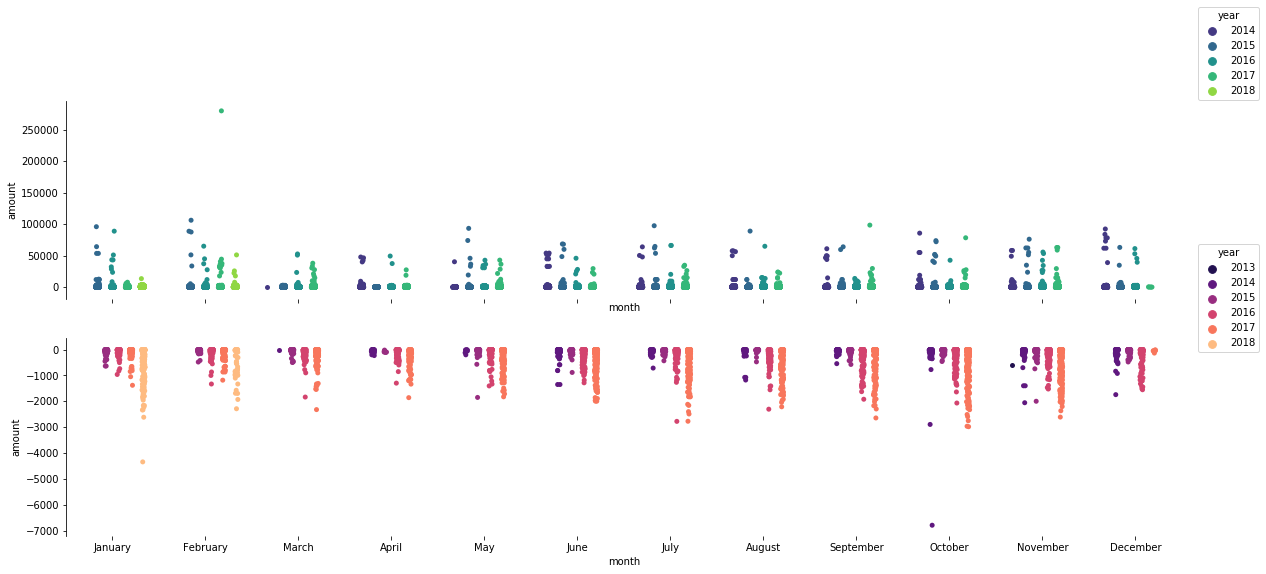

In [215]:
years = list(pos_series['year'].unique())
years.sort()
num_years = len(years
#order of months
month_order=['January','February','March','April',
            'May','June','July','August','September',
            'October','November','December']
#month names for labels
month_names = ['JAN','FEB','MAR',
               'APR','MAY','JUN',
               'JUL','AUG','SEP',
               'OCT','NOV','DEC']
fig,subfigure = plt.subplots(2,1,figsize=(20,8),sharex=True)
sns.stripplot(data=pos_series,x='month',
                y='amount',hue='year',size=5,
                ax=subfigure[0],
                palette='viridis',
                dodge=True,
                order=month_order)
sns.stripplot(data=neg_series,x='month',
                y='amount',hue='year',size=5,
                ax=subfigure[1],
                palette='magma',
                dodge=True,
                order=month_order)
subfigure[0].legend(title='year',loc='upper left',bbox_to_anchor=(1.01,1.5))
subfigure[1].legend(title='year',loc='upper left',bbox_to_anchor=(1.01,1.5))
sns.despine(bottom=True)
plt.show()

In order to better see the shift in averages (monthly, quarterly and weekly), I wish to use use a monthly moving-median time-series plot (using a window of 30 days) to see if we can better observe this growth in refunds, and observe changes in purchases throughout time.

In [477]:
def rolling_median_plot(time_series,field_name,subfigure,line_color):
    rolling_activity = time_series.rolling(window=30,min_periods=29).median()
    subfigure.plot(rolling_activity[field_name],color=line_color)

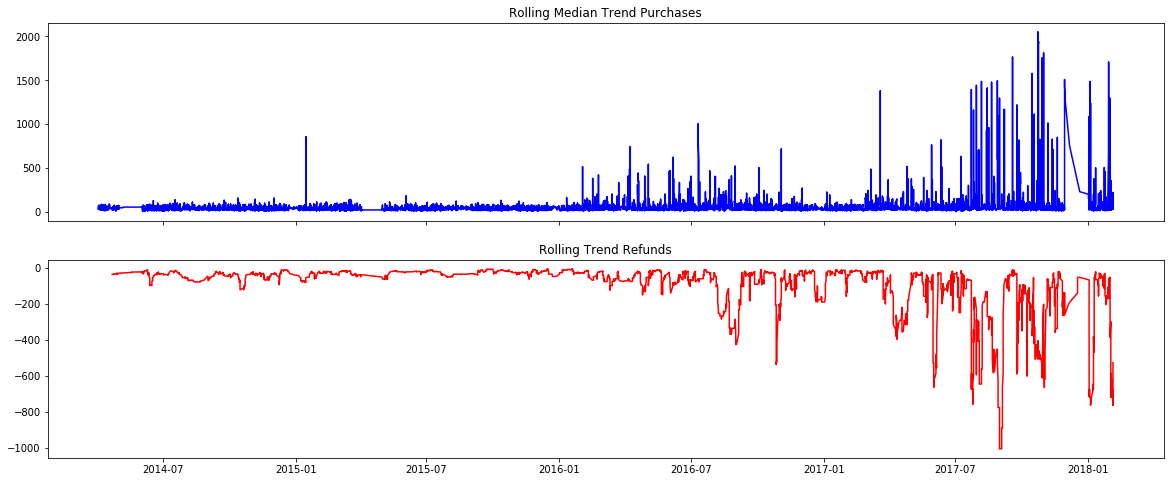

In [476]:
fig,subfigure = plt.subplots(2,1,figsize=(20,8),sharex=True)
subfigure[0].set_title('Rolling Median Trend Purchases')
subfigure[1].set_title('Rolling Trend Refunds')
rolling_median_plot(pos_series,'amount',subfigure[0],'blue')
rolling_median_plot(neg_series,'amount',subfigure[1],'red')
plt.show()

With these moving-average plots we can see better the motions of both purchase and refund amounts. Notice that the limits of refunds falls within the 1000 GBP daily limit. However, moving monthly averages, though in the low values surpass the 1000 GBP limit in many ocassions. Perhaps there is a combination of purchases in GBP and foreign currencies (perhaps like Rupies or Colombian Pesos that are in the thousands), that skew this daily moving median (in a 30 days windows).

Notice that both purchases and refunds do not seem *stationary* in the sense that they behave the same throughout time. Notice that the median amount of purchases and refunds begins increasing at the start of 2016, and has a serious spike throughout the second half of 2017. Notice that both refunds and purchases are somehow *synchronized* throughout this spikes, and an increase in the median value of purchases is accompanied by an increase in the median value of refunds. 

However, in order to see this, we need to test both of these series for *correlation* somehow.  

In [417]:
rolling_pos = pos_series.rolling(window=30,min_periods=29).median()
rolling_pos = rolling_pos.dropna()
rolling_neg = neg_series.rolling(window=30,min_periods=29).median()
rolling_neg = rolling_neg.dropna()

Let's see first their distribution as histograms using the following plot:

In [412]:
def plot_histogram(data,subfigure,fig_color,fig_name):
    subfigure.set_title(fig_name)
    sns.distplot(data['amount'],
                 kde=True,
                 bins=100,
                 ax=subfigure,
                 color = fig_color)

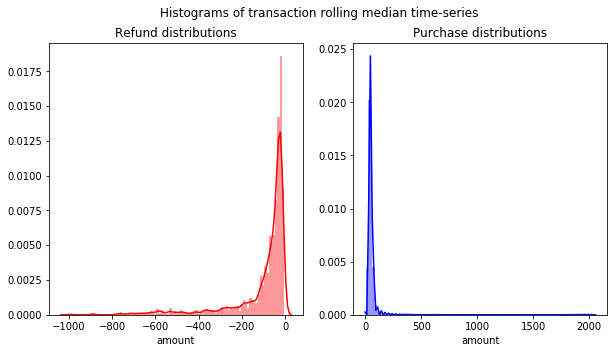

In [472]:
fig,subfigure = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Histograms of transaction rolling median time-series')
plot_histogram(rolling_neg,subfigure[0],'red','Refund distributions')
plot_histogram(rolling_pos,subfigure[1],'blue','Purchase distributions')
plt.show()

These histograms suggest that neither purchases nor refunds are normally distributed. If we subdivide purchases and refunds per month, to see if there are any seasonal trends we get the following KDE plots: 

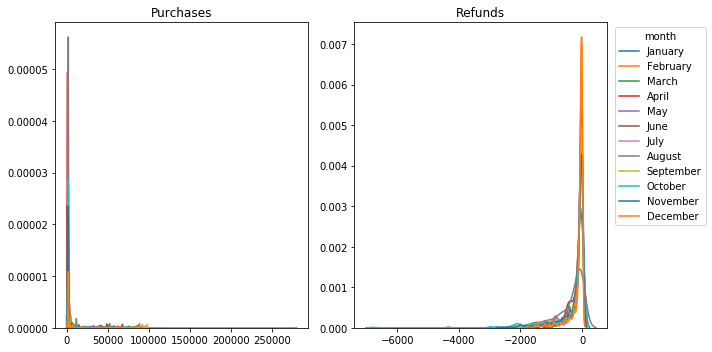

In [496]:
fig,subfigure = plt.subplots(1,2,figsize=(10,5))
subfigure[0].set_title('Purchases')
subfigure[1].set_title('Refunds')
for month in month_order:
    month_data = transactions.loc[transactions['month']==month]
    purchases = month_data.loc[month_data['amount']>0]
    refunds = month_data.loc[month_data['amount']<0]
    sns.kdeplot(data=purchases['amount'],ax=subfigure[0],label=month)
    sns.kdeplot(data=refunds['amount'],ax=subfigure[1],label=month)

subfigure[0].legend().remove()
subfigure[1].legend(title='month',loc='upper left',bbox_to_anchor=(1.01,1.0))
plt.tight_layout()
plt.show()

Notice that my intuition stands. There is no resemblence to normality for any month. Moreover, notice that purchases have a much more *skewed* distribution than refunds. When dividing the amounts per-month, we also notice that there are differences in the height of the distributions (i.e. the probability), this suggests that there are *trends* within these time-series. 

These KDE plots purchase plots however, are completely uninforming since the distribution is so sharply skewed. My guess is that this is due to the *wide* support of purchases due to currency exchanges. In order to see if purchases and refunds are normally distributed, let's do a quick normality test using the D'Agostino-$K^2$ test, with the *SciPy* library. 

I will use the standard confidence of $95\%$ (i.e. a significance of $\alpha=5\%$). The  hypothesis we wish to put to the test is:

$$H_0: \text{amount} \sim N(\mu,\sigma)$$


In [254]:
def normality_test(series_sample,alpha):
    k2,p = stats.normaltest(series_sample)
    print('Test outcomes','p=',p,'k2=',k2)
    if p < alpha:
        print('There is evidence to reject the null hypothesis')
    else:
        print('There is no evidence to reject the null hypothesis')

In [468]:
print('Normality Test for purchases')
normality_test(rolling_pos['amount'],0.05)
print()
print('Normality Test for refunds')
normality_test(rolling_neg['amount'],0.05)

Normality Test for purchases
Test outcomes p= 0.0 k2= 339013.73411998205
There is evidence to reject the null hypothesis

Normality Test for refunds
Test outcomes p= 0.0 k2= 2832.5950979511663
There is evidence to reject the null hypothesis


Indeed, neither purchases nor refunds are normally distributed (check the p-value). Moreover, the skewness of both purchases and refunds is high (the value of the $K^2$ is through the roof). The implication here is that perhaps purchases and refunds are *non-stationary* as a time series. This means, that there are seasonal patterns and the amount (purchased and refunded) depends on time (as the moving-average plot suggests). However, since purchases nor refunds are normally distributed, the classical Dickey-Fuller Test may be misleading and I have to resort to a non-parametric test. 

I will use the Mann-Kendall Test, that relies on the Mann-Kendall $S$-score 

$$ S = \sum_{k=1}^{n-1}\sum_{j=k+1}^{n} sign(x_j-x_k)$$

and its variance calculated from the *tied groups* of the time-series (i.e. points in the time series that coincide in value) as:

$$Var(S) = \frac{1}{18}\left[n(n-1)(2n+5)-\sum_{p=1}^{M}t_p(t_p-1)(2t_p+5)\right]$$

where $M$ is the number of tied groups in the time series and $t_p$ is the number of members in the group (observations sharing the same amount value). The Mann-Kendall Test depends on p-value of the following quantity

$$
z = \frac{S\pm 1}{\sqrt{Var(S)}}
$$
where a sum is used when $S>0$ and a minus is used when $S<0$, associated with a standard normal distribution. That is:

$$
p = \frac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
If $p$ is below the significance level, there is no trend within the time series. If $p=0$ the test is undecisive, and if $p$ is above the significante level, then the sign of $Z$ tells us that the trend is *increasing* (whenever $Z>0$) or *decreasing* (whenever $Z<0$). 

The following block of instructions contains the routine for the Mann-Kendall Test:

In [464]:
def var_S(time_series):
    n = len(time_series)
    groups_dict = dict(time_series['amount'].value_counts())
    groups_sum = 0
    for group in groups_dict.keys():
        t_p = groups_dict[group]
        groups_sum += t_p*(t_p-1)*(2*t_p+5)
    return (1.0/18.0)*(n*(n-1)*(2*n+5)-groups_sum)

def S(values):
    S = 0
    for k in range(len(values)-1):
        for j in range(k+1,len(values)):
            S += np.sign(values[j]-values[k])
    return S

def Mann_Kendall_Test(series,significance):
    #we will simplify this series to keep only distinct dates
    resample = pd.pivot_table(series,
                              index=series.index,
                              values='amount',
                              aggfunc='median').reset_index()
    S_score = S(list(resample['amount']))
    var = var_S(resample)
    Z = 0
    if S_score >0:
        Z = (S_score-1)/np.sqrt(var)
    elif S_score <0:
        Z = (S_score+1)/np.sqrt(var)
    else:
        Z = 0
    p_value = stats.norm(0,1).cdf(Z)
    print('S-Score',S_score)
    print('S-variance',var)
    print('p-value',p_value)
    print('Test result:',end=' ')
    if p_value < significance:
        print('There is no Trend')
    else:
        if Z<0:
            print('Trend is decreasing')
        else:
            print('Trend is increasing')


We will apply now the Mann-Kendall test to the purchase and refund rolling median time series. However, since we have around 190 thousand transactions, I will simplify these series using the *daily median* of the series to significantly reduce the points in the series, since the $S$-score is an $O(n^2)$ procedure.   

In [471]:
print('Mann-Kendall Trend test for purchases')
Mann_Kendall_Test(rolling_pos,0.05)
print()
print('Mann-Kendall Trend test for refunds')
Mann_Kendall_Test(rolling_neg,0.05)

Mann-Kendall Trend test for purchases
-----------------------------------
Mann Kendall Homemade Test Results
-----------------------------------
S-Score 103182.0
S-variance 257006106.0
p-value 0.9999999999387401
Test result: Trend is increasing

Mann-Kendall Trend test for refunds
-----------------------------------
Mann Kendall Homemade Test Results
-----------------------------------
S-Score -154308.0
S-variance 115329304.66666666
p-value 4.0704679997850626e-47
Test result: There is no Trend


Notice that although the rolling median time-series plots suggest that both purchases and refunds are non-stationary (i.e. have a trend), the Mann-Kendall test suggests that only purchases are trending *increasingly*. My intuition around it is that, while refunds fall (in a rolling median) within the GPC policy of a daily limit of 1000 GBP, they have a much smoother distribution than purchases (recall the histograms). 

Thus, there is a significant increase in purchases throughout time, but the refunds stay within legal limits. See the following plot featuring the *rolling* deviations, we can see that the deviation in purchases is much larger than the rolling deviation of refunds (rescaled to the daily median). 

In [490]:
def rolling_deviation_plot(time_series,field_name,subfigure,line_color):
    resample = pd.pivot_table(time_series,
                              index=time_series.index,
                              values='amount',
                              aggfunc='std').reset_index()
    rolling_activity = resample.rolling(window=30,min_periods=29).std()
    subfigure.plot(rolling_activity[field_name],color=line_color)

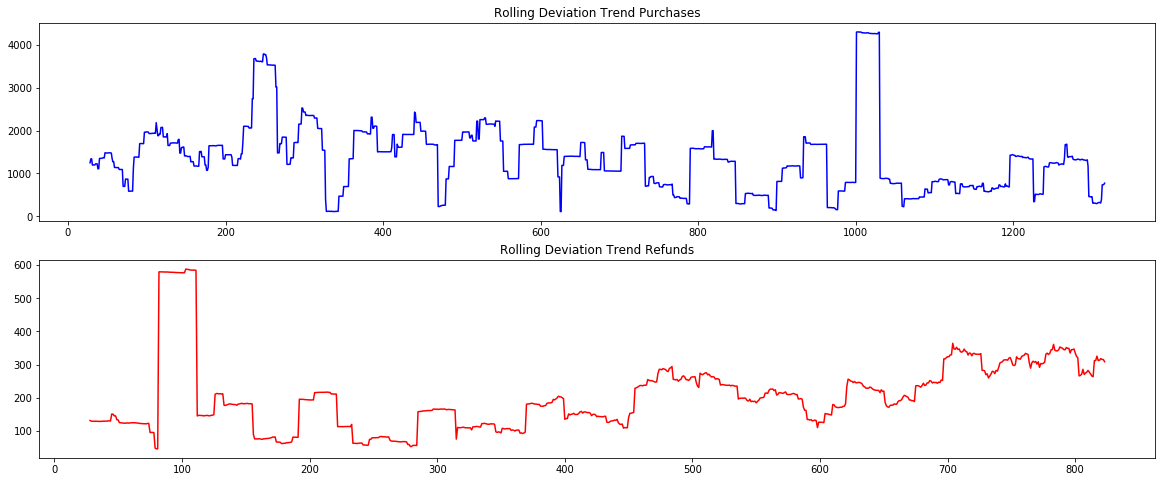

In [492]:
fig,subfigure = plt.subplots(2,1,figsize=(20,8))
subfigure[0].set_title('Rolling Deviation Trend Purchases')
subfigure[1].set_title('Rolling Deviation Trend Refunds')
rolling_deviation_plot(pos_series,'amount',subfigure[0],'blue')
rolling_deviation_plot(neg_series,'amount',subfigure[1],'red')
plt.show()

## Fifth Task: Characterizing *Strange* purchases via Weierstrass's M. 

Although the GPC Policy states that GPC have a maximum daily amount of 1000 GBP, the dataset features transaction amounts *way off* that value. In my interpretation, foreign currencies skew this values, particularly when the transaction is done in a currency with several zeros (e.g. Colombian Peso). In order to see the prevalence of these large values, I wish first to see how both purchase and refunds are divided into *percentiles*. I will choose to split both refunds and purchases into *deciles* (i.e. percentiles of width $10\%$:

In [322]:
pos_series['quantile'] = pd.qcut(pos_series['amount'],q=10)
neg_series['quantile'] = pd.qcut(neg_series['amount'],q=10)

now we can plot the decile distribution using a bar plot. Since the *qcut* function will *evenly* divide a sample into *bins*, I am interested in two things: (1) seeing the *ranges* of the bins and (2) the number of transactions in each bin. 

We have already seen that this dataset is heavily skewed to the left. The question I wish to solve first is *how* skewed is it? 

In [329]:
def percentile_barplot(transactions,subfigure,fig_color):
    quantile_distro=pd.pivot_table(transactions,index='quantile',aggfunc='count')
    quantile_distro.plot.barh(ax=subfigure,label=False,color=fig_color,legend=False)

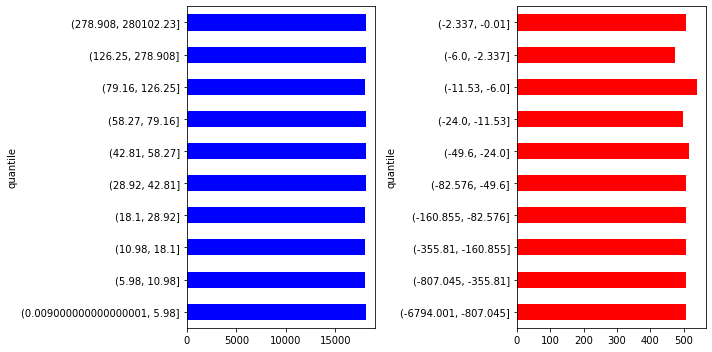

In [330]:
fig,subfigure = plt.subplots(1,2,figsize=(10,5))
percentile_barplot(pos_series,subfigure[0],'blue')
percentile_barplot(neg_series,subfigure[1],'red')
plt.tight_layout()
plt.show()

As predicted, the ranges of the bins are also skewed. Notice that the first 7 bins for purchases are below 100 GBP. More specifically 70% of all purchases are below 79.16 (presumably) GBP. In contrast notice that the first 6 bins of all refunds are below the 100 (presumably) GBP limit, that is 60% of refunds were done for values less than 82.57 (presumably) GBP. 

If we take a look at the last *decile* of both purchases and refunds, we see that the lower limit of the last decile is 278.9 (presumably) GBP, while the last *decile* of refunds is 807.045 (presumably) GBP. According to the CPG Policy handbook, these transactions are well below the 1000 GBP limit. Let's have a look at transactions using the 278 (presumably GBP) limit for purchases, and the 807.045 (presumably GBP) for refunds. I will divide transactions then in *regular* transactions (within the 90% limits) and the *strange* transactions beyond them.   

In [493]:
regular = transactions.loc[(transactions['amount']>=-807.045) & (transactions['amount']<=378.908)]
strange = transactions.loc[(transactions['amount']<-807.045) | (transactions['amount']>378.908)]
num_regular = len(in_gbp)
num_strange = len(in_foreign)
prev_regular = 100*float(num_gbp)/float(transaction_stats['count'])
prev_strange = 100*float(num_foreign)/float(transaction_stats['count'])
print('Prevalence of regular transactions',"{:,.2f}%".format(prev_gbp))
print('Prevalence of strange transactions',"{:,.2f}%".format(prev_foreign))

Prevalence of regular transactions 96.57%
Prevalence of strange transactions 3.43%


Thus, 96.57% of transactions are within these limits (combining refunds and purchases), and only 3.43% fall in the strange category. Let's plot their distribution of amounts:

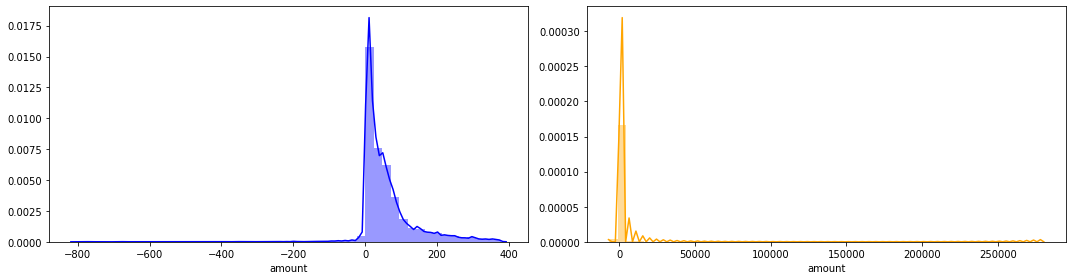

In [494]:
fig,subfigure = plt.subplots(1,2,figsize=(15,4))
sns.distplot(regular['amount'],ax=subfigure[0],color='blue')
sns.distplot(strange['amount'],ax=subfigure[1],color='orange')
plt.tight_layout()
plt.show()

Notice that although the regular purchases resemble a normal distribution, there is a sharp drop in the negative part of the regular transactions histogram. If we perform a normality test on regular and strange distributions we get the following:

In [531]:
print('Normality Test for regular transactions')
normality_test(regular['amount'],0.05)
print()
print('Normality Test for strange transactions')
normality_test(strange['amount'],0.05)

Normality Test for regular transactions
Test outcomes p= 0.0 k2= 37051.90008036482
There is evidence to reject the null hypothesis

Normality Test for strange transactions
Test outcomes p= 0.0 k2= 27490.84307606466
There is evidence to reject the null hypothesis


Thus, neither regular nor irregular transactions can be regarded as normal. According to the limits, we see that purchases falling in the range $(0,378.908)$ can be regarded as *usual*: they fall way within the expected legal limit of 1000. I wish to subdivide purchases from this limit onward (up to the legal limit) and I propose the following division:

- *tiny* purchases: below 378.908 
- *small* purchases: between 378.908  and 1000 
- *medium* purchases: between 1.000  and 10.000 
- *large* purchases: between 10.000  and 100.000 
- *extra large* purchases: over 100.000

In [505]:
purchase_type ={'tiny':[0,378.908],
                'small':[378.908,1000],
                'medium':[1000,10000],
                'large':[10000,100000],
                'extra large':[100000,300000]}

With this bounds and the purchase_types, we can plot now their KDE distributions. I choose to plot these by month to give these plots *a little flavor*: 

No handles with labels found to put in legend.


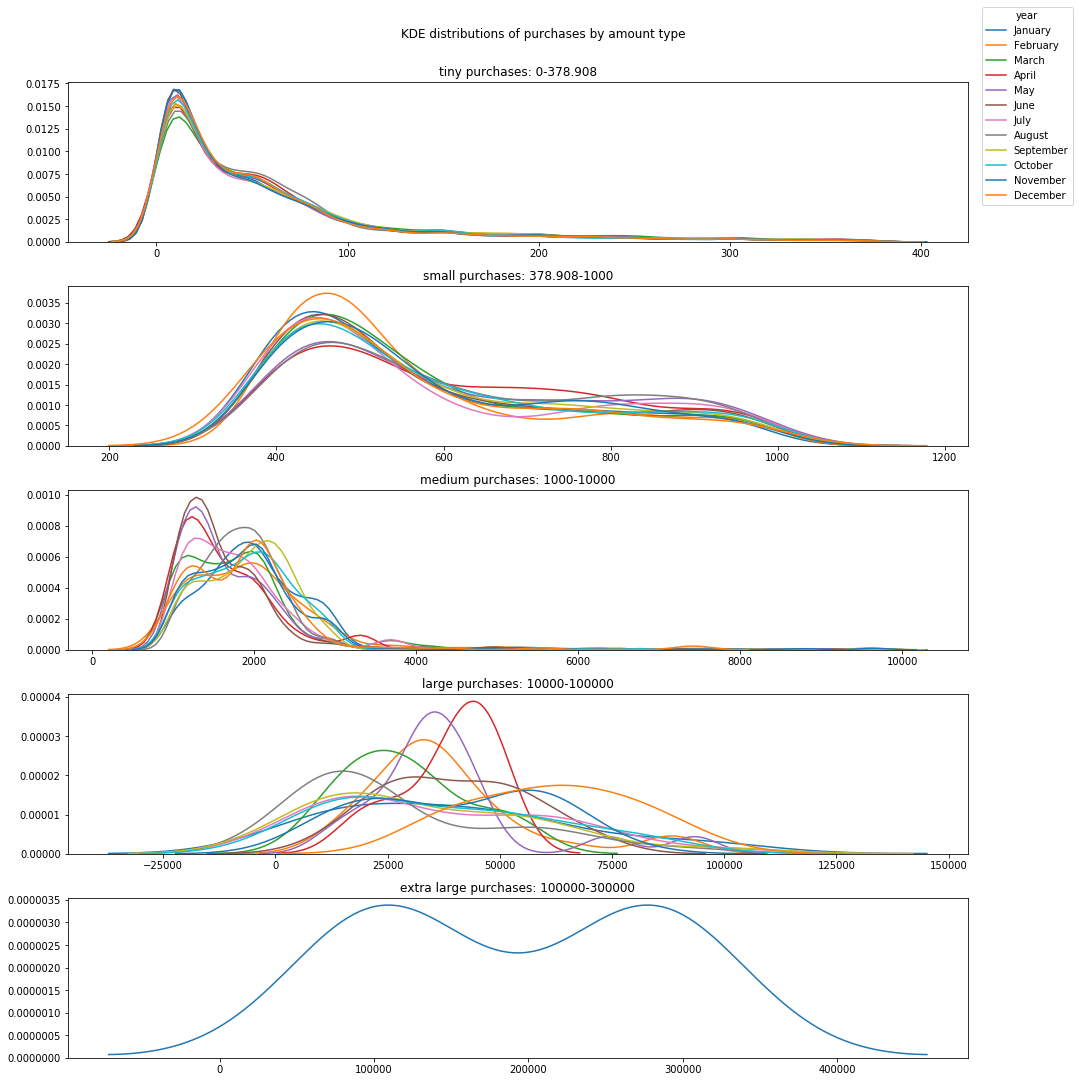

In [498]:
fig,subfigure=plt.subplots(5,1,figsize=(15,15))
fig.suptitle('KDE distributions of purchases by amount type')
for month in month_order:
    month_data = pos_series.loc[pos_series['month']==month]
    for i,ty in enumerate(purchase_type.keys()):
        bounds = purchase_type[ty]
        type_data = month_data.loc[(month_data['amount']>=bounds[0]) & (month_data['amount']<bounds[1])]
        sns.kdeplot(data=type_data['amount'],ax=subfigure[i],label=month)
        subfigure[i].set_title(ty+' purchases: '+str(bounds[0])+'-'+str(bounds[1]))
        subfigure[i].legend().remove()

subfigure[0].legend(title='year',loc='upper left',bbox_to_anchor=(1.01,1.5))
plt.tight_layout()
plt.show()

Notice that the probability for this division of purchases decreases according to category. This is, the *range* of the KDE regression shortens. Since the KDE regression is a proxy for a probability distribution, this maximum value will be useful to determine (probabilistically), how *likely* is a purchase. I will collect these upper limits in a dictionary. I wish to also include a function that given an amount for a purchase, it will give us its *type*.  

In [528]:
purchase_probs ={'tiny':0.0175,
                'small':0.0035,
                'medium':0.00010,
                'large':0.000004,
                'extra large':0.00000035}

def get_purchase_type(amount):
    if amount >= purchase_type['tiny'][0] and amount < purchase_type['tiny'][1]:
        return 'tiny'
    elif amount >= purchase_type['small'][0] and amount < purchase_type['small'][1]:
        return 'small'
    elif amount >= purchase_type['medium'][0] and amount < purchase_type['medium'][1]:
        return 'medium'
    elif amount >= purchase_type['large'][0] and amount < purchase_type['large'][1]:
        return 'large'
    else:
        return 'extra large'

Since purchases of neither type are normaly distributed, we cannot use a $Z$-score based approach to detecting the likelyhood of a transaction of a particular amount (i.e. standarizing). However, we can estimate the probability of encountering tiny, small, medium, large and extra-large purchases using the bounds proposed in the *purchase_probs* dictionary. 

From classical probability we know that given a purchase of an amount $a$, and type $T(a)$ we can estimate the probability of occurence of $a$ within it's type via its probability distribution $p_T(x)$ (the KDE regression) as:

$$P(X\leq a) = \int_{T_0}^a p_T(x)dx$$

where $T_0$ is the lowest value in the support of $p_T$ By Weierstrass' M bound, we know that this integral is bound via

$$\int_{T_0}^a p_T(x)d\mu \leq M_T(a-T_0)$$

where $M_T$ is the *maximum* value that $p_T$ takes. Notice that this integral is not under the Riemann measure, that I will not calculate in this Notebook. The following block of code provides us with a proxy for the *likelihood* of an amount, as an upper bound for its probability based on Weierstrass's M:

In [524]:
def prob_bound(amount):
    amount_type = get_purchase_type(amount)
    limits = purchase_type[amount_type]
    M = purchase_probs[amount_type]
    return M*(amount-limits[0])

thus, we can now estimate the probability of a purchase being *likely* and *unlikely* from this Weierstrass M method. Since the range of the amounts is widely sparse, this is not exactly a probability: probability integrals are to be taken under a particular measure, that I'm replacing here with a simple multiplication. Consequently, we end up with a number that characterizes a likelihood, more than a probability. 

In [536]:
purchases = transactions.loc[transactions['amount']>0]
purchases['purchase_type'] = purchases.apply(lambda row: get_purchase_type(row['amount']),axis=1)
purchases['likelihood'] = purchases.apply(lambda row: prob_bound(row['amount']),axis=1)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [538]:
likelihood_summary = pd.pivot_table(purchases,index='purchase_type',values='likelihood',aggfunc=['mean','std'])
likelihood_summary

,mean,std
,likelihood,likelihood
purchase_type,,
extra large,0.032619,0.043016
large,0.113489,0.087590
medium,0.089585,0.086647
small,0.741767,0.624039
tiny,1.069318,1.236144


Notice that tiny purchases have a likelihood greater than 1 on average, and also a deviation greater than 1, while all other purchase types have both an average and a deviation smaller than 1. Moreover, the second largest group in this likelihood is the *small* purchases that fall within legal limits. My intuition is that this likelihood indicator prizes tiny purchases (as the GPC policy states) and penalizes foreign currency transactions or transactions that are above the legal daily limit. 